In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import cv2


# 1) Load WLAS Dataset #

In [2]:
# Absolute main path
main_path = '../data/'

# Read JSON file into a DataFrame with unprocessed instance col
wlas_df = pd.read_json(main_path + 'WLASL_v0.3.json')

print(wlas_df.head())
print(wlas_df.shape)


      gloss                                          instances
0      book  [{'bbox': [385, 37, 885, 720], 'fps': 25, 'fra...
1     drink  [{'bbox': [551, 68, 1350, 1080], 'fps': 25, 'f...
2  computer  [{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...
3    before  [{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...
4     chair  [{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...
(2000, 2)


# 2) Extract the available videos list from the dataset #

In [3]:
def get_videos_ids(json_list):
    """
    function to check if the video id is available in the dataset
    and return the viedos ids of the current instance

    Input: instance json list
    Output: list of videos_ids
    """
    videos_list = []
    for ins in json_list:
        video_id = ins['video_id']
        if os.path.exists(f'{main_path}videos/{video_id}.mp4'):
            videos_list.append(video_id)
    return videos_list


In [4]:
def get_json_features(json_list):
    """
    function to check if the video id is available in the dataset
    and return the viedos ids and url or any other featrue of the current instance

    input: instance json list
    output: list of videos_ids
    """
    videos_ids = []
    videos_urls = []
    for ins in json_list:
        video_id = ins['video_id']
        video_url = ins['url']
        if os.path.exists(f'{main_path}videos/{video_id}.mp4'):
            videos_ids.append(video_id)
            videos_urls.append(video_url)
    return videos_ids, videos_urls


In [5]:
# Open JSON file (read only)
with open(main_path+'WLASL_v0.3.json', 'r') as data_file:
    json_data = data_file.read()

instance_json = json.loads(json_data)


In [6]:
# Test "get_videos_ids" function with first gloss (word = book) in file
get_videos_ids(instance_json[0]['instances'])[0]


'69241'

In [7]:
# Check output length of function (40 links for book)
# Function returns only ids that can also be found in the 'data/videos' folder
len(get_videos_ids(instance_json[0]['instances']))


6

In [8]:
# Get available video ids for all rows in wlas_df and add to new col 'videos_id'
wlas_df['videos_ids'] = wlas_df['instances'].apply(get_videos_ids)
wlas_df.head()


,gloss,instances,videos_ids
0,book,"[{'bbox': [385, 37, 885, 720], 'fps': 25, 'fra...","[69241, 07069, 07068, 07070, 07099, 07074]"
1,drink,"[{'bbox': [551, 68, 1350, 1080], 'fps': 25, 'f...","[69302, 65539, 17710, 17733, 65540, 17734, 177..."
2,computer,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...","[12328, 12312, 12311, 12338, 12313, 12314, 123..."
3,before,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...","[05728, 05749, 05750, 05729, 05730, 65167, 057..."
4,chair,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...","[09848, 09869, 09849, 09850, 09851, 65328, 09854]"


In [97]:
# Create separate DataFrame for available information in each instance
features_df = pd.DataFrame(columns=['word', 'video_id', 'url'])

for row in wlas_df.iterrows():
    # Extract ids and urls for each row
    ids, urls = get_json_features(row[1][1])
    # Initialize a list matching the length (n) of found ids containing the word
    word = [row[1][0]] * len(ids)
    # Using zip to create new df with:
    # n * word in gloss col (e.g. 6 * book)
    # Unique id and url in ids and url col respectively
    df = pd.DataFrame(list(zip(word, ids, urls)), columns = features_df.columns)
    # Append temporary df to feature_df
    features_df = pd.concat([features_df, df], ignore_index=True)


In [106]:
# Renaming index col to index
features_df.index.name = 'index'
features_df.head()


,word,video_id,url
index,,,
0,book,69241,http://aslbricks.org/New/ASL-Videos/book.mp4
1,book,07069,https://signstock.blob.core.windows.net/signsc...
2,book,07068,https://s3-us-west-1.amazonaws.com/files.start...
3,book,07070,https://media.asldeafined.com/vocabulary/14666...
4,book,07099,http://www.aslsearch.com/signs/videos/book.mp4


In [107]:
# for video_id in features_df['video_id']:
#     if os.path.exists(f'{main_path}videos/{video_id}.mp4'):
#         cap = cv2.VideoCapture(f'{main_path}videos/{video_id}.mp4')
#         length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#         features_df.loc[features_df['video_id'] == video_id, ['video_length']] = int(length)
#     pass


In [43]:
# Creating csv from features_df
features_df.to_csv('../data/features_df.csv', index=False)


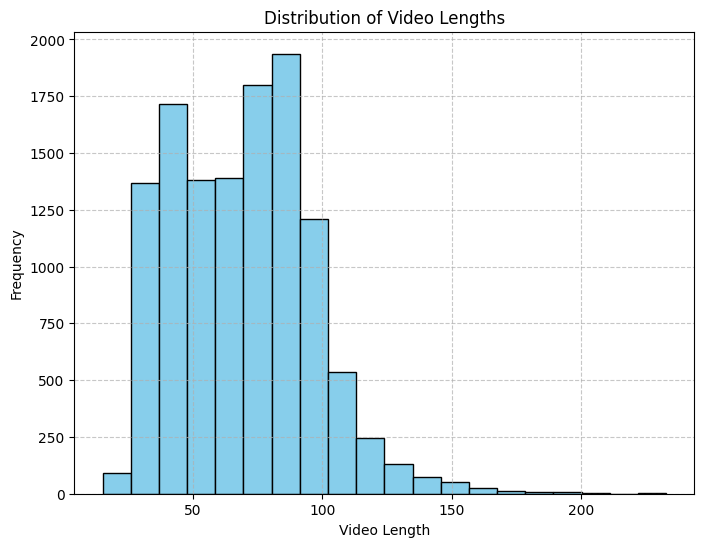

In [46]:
plt.figure(figsize=(8, 6))
plt.hist(features_df['video_length'], bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed

plt.title('Distribution of Video Lengths')
plt.xlabel('Video Length')
plt.ylabel('Frequency')

# Add gridlines and customize axis ticks if required
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show plot
plt.show()


# 3) Dataset Classes analysis #

In [148]:
# Counting number of videos per word in new col 'samples_num'
wlas_df['samples_num'] = wlas_df['videos_ids'].apply(len)
wlas_df = wlas_df.rename(columns={'gloss': 'word'})
wlas_df.head()


,word,instances,videos_ids,samples_num
0,book,"[{'bbox': [385, 37, 885, 720], 'fps': 25, 'fra...","[69241, 07069, 07068, 07070, 07099, 07074]",6
1,drink,"[{'bbox': [551, 68, 1350, 1080], 'fps': 25, 'f...","[69302, 65539, 17710, 17733, 65540, 17734, 177...",15
2,computer,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...","[12328, 12312, 12311, 12338, 12313, 12314, 123...",14
3,before,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...","[05728, 05749, 05750, 05729, 05730, 65167, 057...",16
4,chair,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...","[09848, 09869, 09849, 09850, 09851, 65328, 09854]",7


In [149]:
print("Min number of videos for a word:", wlas_df['samples_num'].min())
print("Max number of videos for a word:", wlas_df['samples_num'].max())


Min number of videos for a word: 2
Max number of videos for a word: 16


In [194]:
# Creating a visualization df, grouping the words with same number of samples
words_sample_counts = wlas_df[['word', 'samples_num']]\
                      .groupby('samples_num')\
                      .agg({"word":['count', ', '.join]}).reset_index()
words_sample_counts = words_sample_counts.rename(columns={'join': 'word'})
words_sample_counts


samples_num  word                                                   
               count                                               word
0            2    14  gloves, careless, wash face, curtain, grey, la...
1            3    76  garage, parents, boots, excuse, furniture, rep...
2            4   335  hello, newspaper, asl, that, will, cards, hate...
3            5   511  clothes, table, movie, clock, pencil, behind, ...
4            6   402  book, birthday, need, have, knife, read, name,...
5            7   307  chair, dance, eat, forget, but, jacket, paint,...
6            8   151  all, blue, hearing, wrong, color, enjoy, time,...
7            9   100  fine, finish, now, can, hat, kiss, cow, meet, ...
8           10    48  year, black, hot, like, many, orange, fish, gr...
9           11    26  deaf, no, walk, mother, woman, dog, family, ap...
10          12    13  yes, what, later, man, shirt, change, corn, da...
11          13     8  candy, thanksgiving, bed, bowling, tall, accid...
12          14     4                        computer, who, cousin, help
13          15     2                                          drink, go
14          16     3                                 before, thin, cool

In [ ]:
filtered_words = []
for i in range(8, 15):
    for word in words_sample_counts.loc[i].values[2].split(', '):
        filtered_words.append(word)
filtered_words


In [231]:
filtered_df = features_df[features_df['word'].isin(filtered_words)]
filtered_df['word'].unique()


array(['drink', 'computer', 'before', 'go', 'who', 'candy', 'cousin',
       'deaf', 'help', 'no', 'thin', 'walk', 'year', 'yes', 'black',
       'cool', 'hot', 'like', 'many', 'mother', 'orange', 'thanksgiving',
       'what', 'woman', 'bed', 'bowling', 'dog', 'family', 'fish',
       'graduate', 'language', 'later', 'man', 'shirt', 'study', 'tall',
       'white', 'accident', 'apple', 'bird', 'change', 'corn', 'dark',
       'doctor', 'give', 'last', 'pizza', 'play', 'secretary', 'short',
       'work', 'basketball', 'cheat', 'full', 'letter', 'son', 'tell',
       'thursday', 'wait', 'bar', 'brother', 'check', 'cry', 'laugh',
       'room', 'snow', 'take', 'why', 'write', 'yesterday', 'bad',
       'blanket', 'call', 'cold', 'daughter', 'example', 'far', 'good',
       'leave', 'soon', 'trade', 'balance', 'because', 'convince', 'fat',
       'government', 'interest', 'order', 'sandwich', 'theory', 'argue',
       'champion', 'delay', 'delicious', 'environment', 'move',
       'persp

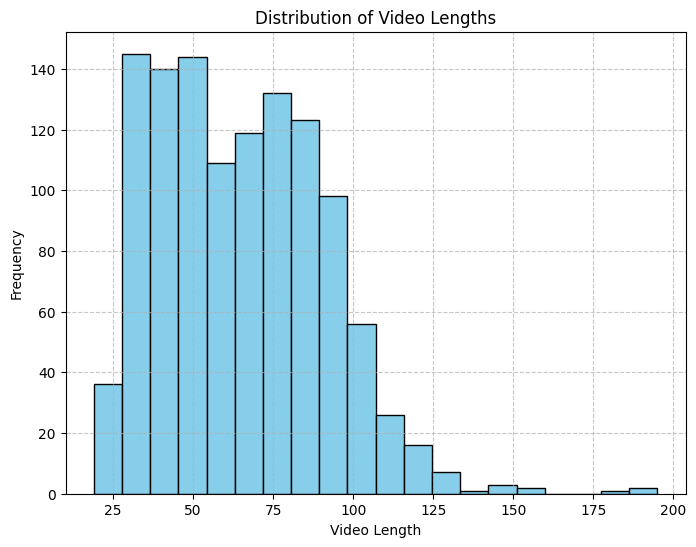

In [223]:
plt.figure(figsize=(8, 6))
plt.hist(filtered_df['video_length'], bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed

plt.title('Distribution of Video Lengths')
plt.xlabel('Video Length')
plt.ylabel('Frequency')

# Add gridlines and customize axis ticks if required
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show plot
plt.show()


In [225]:
filtered_df.describe()


,video_length
count,1160.000000
mean,64.945690
std,25.863309
min,19.000000
25%,44.000000
50%,63.000000
75%,84.000000
max,195.000000


In [189]:
# All the words per number of videos
words_per_samples_num = 11
words_sample_counts.loc[words_per_samples_num].values[1]


8

In [46]:
"""
Download request for additional URLs
"""

# import urllib.request

# url = 'https://www.youtube.com/watch?v=0UsjUE-TXns'
# urllib.request.urlretrieve(url, f'test/test.mp4')

# opener = urllib.request.build_opener()
# opener.addheaders = [('User-agent', 'Mozilla/5.0')]
# urllib.request.install_opener(opener)
# urllib.request.urlretrieve(url, f'test/test.mp4')


'\nDownload request for additional URLs\n'